In [54]:
%matplotlib inline
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from tqdm import tqdm

# json parsing

In [2]:
with open('/opt/ml/detection/dataset/cv_val_1.json', 'r') as file:
    val = json.load(file)
    val_img = pd.DataFrame.from_dict(val['images'])
    val_ann = pd.DataFrame.from_dict(val['annotations'])

### check number of bbox size in json

In [34]:
val_s = val_ann[val_ann['area']<32**2]
val_m = val_ann[(val_ann['area']>=32**2) & (val_ann['area']<96**2)]
val_l = val_ann[(val_ann['area']>=96**2)]
print(len(val_s), len(val_m), len(val_l))

38 639 2204


### select & show 10 images from medium sized cropped bbox (can apply augmentations)

In [72]:
num_img = 10
ann_idx = np.random.choice(len(val_m), num_img)
new_val_m = val_m.iloc[ann_idx]
new_val_m

,image_id,category_id,area,bbox,iscrowd,id
2565,4352,1,2046.12,"[428.1, 432.0, 70.8, 28.9, Paper, Paper, Paper...",0,20677
999,1594,1,3754.62,"[760.3, 315.6, 45.9, 81.8]",0,7466
211,402,0,6475.70,"[508.6, 735.7, 159.5, 40.6]",0,2053
772,1148,0,1270.24,"[61.6, 455.4, 46.7, 27.2]",0,5513
1388,2189,0,2739.10,"[378.4, 273.6, 49.0, 55.9]",0,10426
2539,4310,7,5056.86,"[635.9, 343.0, 62.2, 81.3]",0,20488
1862,3005,6,1660.44,"[484.1, 589.9, 27.4, 60.6]",0,14210
322,655,1,3832.49,"[1.0, 612.8, 87.7, 43.7]",0,3033
2303,3866,7,3403.19,"[0.0, 230.6, 42.7, 79.7]",0,18397
763,1148,0,4260.41,"[132.1, 334.0, 84.7, 50.3]",0,5504


In [ ]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

for row in range(len(new_val_m)):
    fig, ax = plt.subplots(1, 3, dpi=200)
    image_id = str(new_val_m.iloc[row]['image_id']).zfill(4)
    bbox = new_val_m.iloc[row]['bbox']
    category = new_val_m.iloc[row]['category_id']
    image = Image.open(os.path.join('/opt/ml/detection/dataset/train', image_id+'.jpg'))
    image_crop = image.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))
    
    bbox_add_cat = bbox.append(classes[category])

    transform = A.Compose([
        #A.SmallestM#xSize(),
        #A.Transpose(p=1)
        #A.ShiftScaleRotate(p=1),
        #A.RandomSizedBBoxSafeCrop(1024,1024,p=1), # 굳
        #A.Resize(512, 512, p=1),
        #A.Sharpen(p=1)
        #A.RandomScale(p=1)
        #A.RandomResizedCrop(512, 512, p=1)
        #A.CropAndPad(percent=0.5)
        #A.Affine(p=1)
        #A.RandomRotate90(p=1)
        #A.MotionBlur(blur_limit=7,p=1)
        #A.CLAHE(p=1), # 굳
        #A.ColorJitter(p=1)
        #A.MedianBlur(p=1)
        #A.RandomRain(p=1) # 굳
        #A.RandomSnow(p=1)
        #A.RandomSunFlare(p=1)
        #A.RandomToneCurve(p=1) # 굳
        #A.ChannelDropout(p=1)
        #A.ChannelShuffle(p=1)
        #A.HueSaturationValue(p=1)
        A.RandomBrightnessContrast(brightness_limit=[0.0,0.0], contrast_limit=[0.3,0.3], p=1) #굳
    ])

    #image = transform(image=np.asarray(image))['image']
    ax[1].imshow(image_crop)
    image_crop = transform(image=np.asarray(image_crop))['image']
    ax[0].imshow(image)
    ax[0].set_title(classes[category])
    ax[0].add_patch(
         patches.Rectangle(
                    (bbox[0],bbox[1]), bbox[2], bbox[3],
                    edgecolor='red',
                    fill=False,
                    ),
    )
    ax[2].imshow(image_crop)
    print(image_id)
    

# 박스 테이프 이미지 모으기

In [175]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

In [174]:
with open('/opt/ml/detection/dataset/SK_train_annotations.json', 'r') as file:
    train = json.load(file)
    train_img = train['images']
    train_ann = train['annotations']
print(train_ann[:2])
print(len(train_img))
#image_id : 5203 부터 시작


[{'image_id': 1, 'category_id': 3, 'area': 10402.56, 'bbox': [0.0, 407.4, 57.6, 180.6], 'iscrowd': 0, 'id': 1}, {'image_id': 1, 'category_id': 7, 'area': 26259.36, 'bbox': [0.0, 455.6, 144.6, 181.6], 'iscrowd': 0, 'id': 2}]
4298


In [176]:
def cal_iof(Gt, P, ):
    gt_ = []
    p_ = []

    for P_box_ann in P:
        flag = False
        P_box = P_box_ann['bbox']
        for Gt_box_ann in Gt:
            Gt_box = Gt_box_ann['bbox']
            x1 = max(Gt_box[0], P_box[0])
            y1 = max(Gt_box[1], P_box[1])
            x2 = min(Gt_box[0]+Gt_box[2], P_box[0]+P_box[2])
            y2 = min(Gt_box[1]+Gt_box[3], P_box[1]+P_box[3])
            Gt_area = Gt_box[2]*Gt_box[3]
            P_area = P_box[2]*P_box[3]
            
            w = max(0, x2-x1+1)
            h = max(0, y2-y1+1)
            intersect = w*h
            if intersect>0:
                iof = intersect/Gt_area
                if iof >= 0.9 and Gt_area < P_area:
                    gt_.append(Gt_box_ann)
                    flag = True
        if flag:
            p_.append(P_box_ann)
            return flag, gt_, p_
        
    return flag, gt_, p_
        

In [178]:
total_cnt = 0
fnames = []
anns = []
for img in tqdm(train_img, total=len(train_img)):
    img_id = img['id']
    cnt_cls = [0 for _ in range(10)]
    Gt_bbox = []
    P_bbox = []
    S_bbox = []
    flag = False
    for ann in train_ann:
        if ann['image_id']==img_id:
            flag = True
            if ann['category_id'] == 0:  
                cnt_cls[ann['category_id']]+=1
                Gt_bbox.append(ann)
            elif ann['category_id'] == 1:
                cnt_cls[ann['category_id']]+=1
                P_bbox.append(ann)
        elif flag:
            break
    if (cnt_cls[0]>0 and cnt_cls[1]>0):
        flag, gt_ann, p_ann= cal_iof(Gt_bbox, P_bbox)
        if flag:
            fnames.append(img['file_name'])
            anns.append([*gt_ann, *p_ann])
        
print(fnames, len(fnames))
#print(anns)

100%|██████████| 4298/4298 [00:05<00:00, 826.50it/s] 

['train/0004.jpg', 'train/0005.jpg', 'train/0045.jpg', 'train/0051.jpg', 'train/0062.jpg', 'train/0089.jpg', 'train/0108.jpg', 'train/0112.jpg', 'train/0131.jpg', 'train/0154.jpg', 'train/0176.jpg', 'train/0177.jpg', 'train/0183.jpg', 'train/0228.jpg', 'train/0230.jpg', 'train/0235.jpg', 'train/0256.jpg', 'train/0257.jpg', 'train/0275.jpg', 'train/0292.jpg', 'train/0307.jpg', 'train/0310.jpg', 'train/0311.jpg', 'train/0334.jpg', 'train/0352.jpg', 'train/0355.jpg', 'train/0358.jpg', 'train/0384.jpg', 'train/0385.jpg', 'train/0402.jpg', 'train/0449.jpg', 'train/0504.jpg', 'train/0507.jpg', 'train/0556.jpg', 'train/0583.jpg', 'train/0587.jpg', 'train/0600.jpg', 'train/0602.jpg', 'train/0627.jpg', 'train/0694.jpg', 'train/0740.jpg', 'train/0744.jpg', 'train/0761.jpg', 'train/0767.jpg', 'train/0786.jpg', 'train/0796.jpg', 'train/0797.jpg', 'train/0810.jpg', 'train/0819.jpg', 'train/0826.jpg', 'train/0838.jpg', 'train/0843.jpg', 'train/0861.jpg', 'train/0868.jpg', 'train/0894.jpg', 'train/09

# 박스 테이프 이미지 cut mix 적용 후 저장

100%|██████████| 72/72 [00:11<00:00,  6.51it/s]


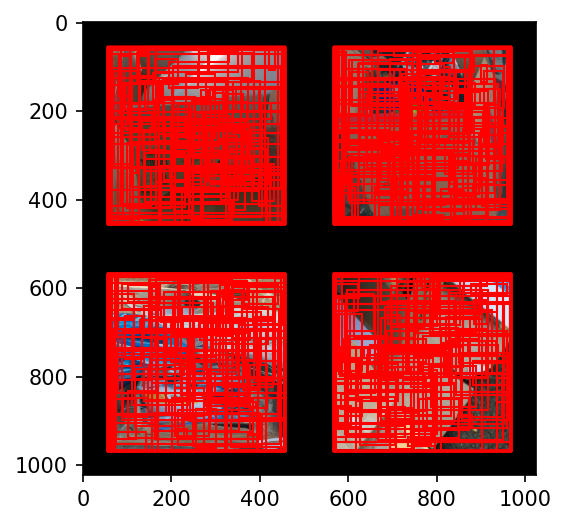

In [179]:
fig, ax = plt.subplots(1, 1, dpi=150)
#{'width': 1024, 'height': 1024, 'file_name': 'train/0001.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2021-01-10 16:30:39', 'id': 1}
new_img_id = 5203
new_ann_id = 23144
new_img_info = []
new_ann_info = []
 
for i in tqdm(range(4,len(anns)-len(anns)%4, 4)):
    
    new_img_info.append({'width': 1024, 'height': 1024, 'file_name': 'train/'+str(new_img_id)+'.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2021-01-10 16:30:39', 'id': new_img_id})
    

    cutmix_img = np.zeros((1024, 1024, 3))
    mix_ann = anns[i:i+4]
    mixed_img = np.zeros((1024, 1024, 3))
    total_bboxes = []
    total_imgs = []
    for ann in mix_ann:
        bboxes = []
        fname = str(ann[0]['image_id']).zfill(4)
        img = Image.open(os.path.join('/opt/ml/detection/dataset/train',fname+'.jpg'))
        x1 = 1024
        y1 = 1024
        x2 = 0
        y2 = 0
        for ann_s in ann:
            x1 = min(x1, ann_s['bbox'][0])
            y1 = min(y1, ann_s['bbox'][1])
            x2 = max(x2, ann_s['bbox'][0]+ann_s['bbox'][2])
            y2 = max(y2, ann_s['bbox'][1]+ann_s['bbox'][3])
        
            bbox_temp = ann_s['bbox'].copy()
            bbox_temp.append(str(ann_s['category_id']))
            bboxes.append(bbox_temp)
            
        transform = A.Compose([
            A.Crop(int(x1),int(y1),int(x2),int(y2)),
            A.Resize(400, 400), 
        ], bbox_params=A.BboxParams(format='coco'))

        new_ann = transform(image=np.asarray(img), bboxes=bboxes)
        new_img = new_ann['image']
        new_box = new_ann['bboxes']
        for i, box in enumerate(new_box):
            new_box[i] = (box[0]+56, box[1]+56, box[2], box[3], box[4])
        img_np = np.pad(new_img, (((56, 56),(56,56), (0,0))))
        total_imgs.append(img_np)
        total_bboxes.append(new_box)

        # ax.imshow(img_np)
        # ax.add_patch(
        #         patches.Rectangle(
        #             (new_box[0][0]+56,new_box[0][1]+56), new_box[0][2], new_box[0][3],
        #             edgecolor='red',
        #             fill=False,
        #             ),
        #         )
        # ax.add_patch(
        # patches.Rectangle(
        #     (new_box[1][0]+56,new_box[1][1]+56), new_box[1][2], new_box[1][3],
        #     edgecolor='red',
        #     fill=False,
        #     ),
        # )
    concatenated_img = np.concatenate((np.concatenate((total_imgs[0], total_imgs[1]), axis=1),np.concatenate((total_imgs[2], total_imgs[3]), axis=1)), axis=0)

    ax.imshow(concatenated_img)
    
    for i, boxes in enumerate(total_bboxes):
        for j, box in enumerate(boxes):
            total_bboxes[i][j]=(box[0]+512*(i%2), box[1]+512*(i//2), box[2], box[3], box[4])
            ax.add_patch(
            patches.Rectangle(
                (total_bboxes[i][j][0],total_bboxes[i][j][1]), total_bboxes[i][j][2], total_bboxes[i][j][3],
                edgecolor='red',
                fill=False,
                ),
            )
            cat_id = int(total_bboxes[i][j][4])
            bbox_temp = list(total_bboxes[i][j][:4])
            area = total_bboxes[i][j][2]*total_bboxes[i][j][3]
            new_ann_info.append({'image_id': new_img_id, 'category_id': cat_id, 'area': area, 'bbox': bbox_temp, 'iscrowd': 0, 'id': new_ann_id})
            new_ann_id+=1
    new_fname = os.path.join('/opt/ml/detection/dataset/train', str(new_img_id)+'.jpg')
    PIL_img = Image.fromarray(concatenated_img)
    PIL_img.save(new_fname)
    new_img_id+=1

In [180]:
train['images']+=new_img_info
train['annotations'] += new_ann_info

In [181]:
with open('/opt/ml/detection/dataset/negative_mining.json', 'w', encoding='utf-8') as make_file:
        json.dump(train, make_file, indent='\t')